# Import statements and data preperation

In [116]:
import numpy as np
import pandas as pd
import os
from PIL import Image 
import matplotlib.pyplot as plt
import random
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns
from collections import Counter

import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Concatenate, Dot, Lambda, Input, Dropout, Conv1D, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50


>Creating list of images and labels (each folder in the dataset is taken as a class)



In [117]:
base="/content/drive/MyDrive/dataset"
c=0
x=[]
y=[]
class_names = []
SIZE = 224
for folder in os.listdir(base):
  class_names.append(folder)
  for pic in os.listdir(base+"/"+folder):
    img=Image.open(base+"/"+folder+"/"+pic)
    img=img.resize((SIZE,SIZE))
    x+=[np.array(img)]
    y+=[c]
  c+=1   
x=np.array(x)
y=np.array(y)

In [118]:
print("shape of image list x =",x.shape) 
print("shape of class list y =",y.shape)

shape of image list x = (75, 224, 224, 3)
shape of class list y = (75,)


> Making pairs of images along with label to feed into Siamese network

In [119]:
def make_pairs(x, y):
    num_classes = len(os.listdir(base))
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]
    print(digit_indices)
    pairs = []
    labels = []
    for idx1 in range(len(x*2)):
        # add a matching example
        x1 = x[idx1]
        label1 = y[idx1]
        idx2 = random.choice(digit_indices[label1])
        x2 = x[idx2]
        
        pairs += [[x1, x2]]
        labels += [1]
    
        # add a not matching example
        label2 = random.randint(0, num_classes-1)
        while label2 == label1:
            label2 = random.randint(0, num_classes-1)

        idx2 = random.choice(digit_indices[label2])
        x2 = x[idx2]
        
        pairs += [[x1, x2]]
        labels += [0]
        

    return np.array(pairs), np.array(labels)

In [120]:
pairs_x,pairs_y=make_pairs(x,y)

[array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([ 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]), array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29]), array([30, 31, 32, 33, 34, 35, 36, 37, 38]), array([39, 40, 41, 42, 43, 44, 45, 46, 47, 48]), array([49, 50, 51, 52, 53, 54, 55, 56, 57, 58]), array([59, 60, 61, 62, 63, 64, 65, 66]), array([67, 68, 69, 70, 71, 72, 73, 74])]


In [121]:
print("shape of image pairs array is",pairs_x.shape)
print("shape of labels array is",pairs_y.shape)

shape of image pairs array is (150, 2, 224, 224, 3)
shape of labels array is (150,)


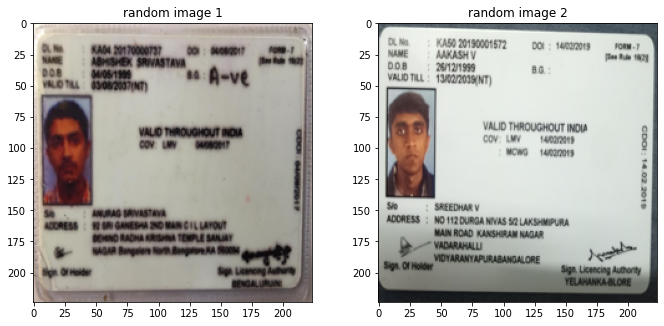

label for this pair is 1


In [222]:
rand = random.randrange(0, pairs_x.shape[0], 1)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout(pad=3)
ax[0].imshow(pairs_x[rand][0])
ax[0].set(title='random image 1')
ax[1].imshow(pairs_x[rand][1])
ax[1].set(title='random image 2')
plt.show()
print("label for this pair is",pairs_y[rand])

> Splitting the dataset into training and testing sets



In [123]:
pairs_train_x, pairs_test_x, pairs_train_y, pairs_test_y = train_test_split(pairs_x,pairs_y, test_size=0.33, random_state=5,stratify=pairs_y)

In [124]:
print("training set shape:",pairs_train_x.shape)
print("training set labels shape:",pairs_train_x.shape)
X=x
Y=y

training set shape: (100, 2, 224, 224, 3)
training set labels shape: (100, 2, 224, 224, 3)


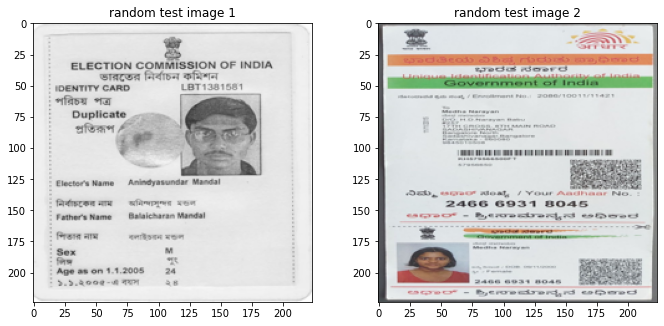

label for this test pair is 0


In [228]:
rand = random.randrange(0, pairs_test_x.shape[0], 1)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout(pad=3)
ax[0].imshow(pairs_test_x[rand][0])
ax[0].set(title='random test image 1')
ax[1].imshow(pairs_test_x[rand][1])
ax[1].set(title='random test image 2')
plt.show()
print("label for this test pair is",pairs_test_y[rand])

> **Cosine Similarity between Embeddings(vectors)**

In [126]:
def cosine_similarity(vects):
  x, y = vects
  dotxy = Dot(axes=1)([x, y])
  magx  = K.sqrt(Dot(axes=1)([x,x]))
  magy  = K.sqrt(Dot(axes=1)([y,y]))
  return (dotxy/(magx*magy))

In [127]:
cosine_similarity([tf.constant([[1.9,1.8]]),tf.constant([[1.9,1.9]])])

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.9996349]], dtype=float32)>

# Initial trial Model

In [128]:
input = Input((SIZE,SIZE,3))
x = Flatten()(input)
x = Dense(28, activation='relu')(x)
x = Dense(52, activation='relu')(x)
dense = Model(input, x)


input1 = Input((SIZE,SIZE,3))
input2 = Input((SIZE,SIZE,3))

dense1 = dense(input1)
dense2 = dense(input2)

output_layer = Lambda(cosine_similarity)([dense1,dense2])
model = Model(inputs=[input1, input2], outputs=output_layer)

In [129]:
model.compile(loss = "binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_26 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_27 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model_16 (Functional)           (None, 52)           4216320     input_26[0][0]                   
                                                                 input_27[0][0]                   
__________________________________________________________________________________________________
lambda_8 (Lambda)               (None, 1)            0           model_16[0][0]            

In [130]:
a=pairs_train_x[:,0]
b=pairs_train_x[:,1]
c=pairs_test_x[:,0]
d=pairs_test_x[:,1]
history=model.fit([a,b], pairs_train_y,batch_size=50, epochs= 5, validation_data=([c,d], pairs_test_y))

Epoch 1/5
2/2 [==============================] - 1s 208ms/step - loss: 2.5077 - accuracy: 0.4933 - val_loss: 3.6004 - val_accuracy: 0.5000
Epoch 2/5
2/2 [==============================] - 0s 50ms/step - loss: 3.3153 - accuracy: 0.4800 - val_loss: 3.0336 - val_accuracy: 0.5000
Epoch 3/5
2/2 [==============================] - 0s 46ms/step - loss: 2.4802 - accuracy: 0.5267 - val_loss: 2.7289 - val_accuracy: 0.5000
Epoch 4/5
2/2 [==============================] - 0s 56ms/step - loss: 2.2418 - accuracy: 0.5133 - val_loss: 2.5043 - val_accuracy: 0.5000
Epoch 5/5
2/2 [==============================] - 0s 46ms/step - loss: 2.1094 - accuracy: 0.5067 - val_loss: 2.3588 - val_accuracy: 0.5000


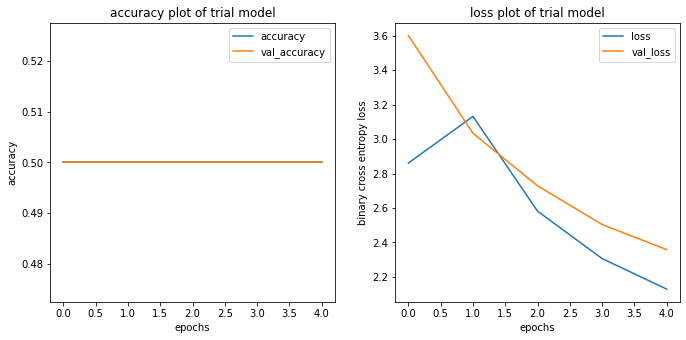

In [131]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout(pad=3)
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].legend(['accuracy', 'val_accuracy'])
ax[0].set(title='accuracy plot of trial model', ylabel='accuracy', xlabel='epochs')
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].legend(['loss', 'val_loss'])
ax[1].set(title='loss plot of trial model', ylabel='binary cross entropy loss', xlabel='epochs')
plt.show()

# VGG16 based Transfer Learning Model

In [132]:
input1 = Input((SIZE,SIZE,3))
input2 = Input((SIZE,SIZE,3))
base_model = VGG16(weights='imagenet',input_shape=(SIZE, SIZE, 3), include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='sigmoid')(x)
# x = Dense(256, activation='sigmoid')(x)
for layer in base_model.layers:
    layer.trainable = False
vgg_model = Model(inputs=base_model.input, outputs=x)

vgg_encoded1 = vgg_model(input1)
vgg_encoded2 = vgg_model(input2)
    
output_layer = Lambda(cosine_similarity)([vgg_encoded1,vgg_encoded2])
siamese_net_1 = Model(inputs=[input1,input2],outputs=output_layer)

In [133]:
siamese_net_1.compile(loss = "binary_crossentropy", optimizer="adam", metrics=["accuracy"])
siamese_net_1.summary()

Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_29 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model_18 (Functional)           (None, 512)          15764800    input_28[0][0]                   
                                                                 input_29[0][0]                   
__________________________________________________________________________________________________
lambda_9 (Lambda)               (None, 1)            0           model_18[0][0]            

In [134]:
a=pairs_train_x[:,0]
b=pairs_train_x[:,1]
c=pairs_test_x[:,0]
d=pairs_test_x[:,1]
history=siamese_net_1.fit([a,b], pairs_train_y,batch_size=50, epochs= 25, validation_data=([c,d], pairs_test_y))

Epoch 1/25
2/2 [==============================] - 3s 1s/step - loss: 1.1374 - accuracy: 0.4933 - val_loss: 0.6533 - val_accuracy: 0.5000
Epoch 2/25
2/2 [==============================] - 2s 998ms/step - loss: 0.5732 - accuracy: 0.6400 - val_loss: 0.4174 - val_accuracy: 0.7800
Epoch 3/25
2/2 [==============================] - 2s 1s/step - loss: 0.3528 - accuracy: 0.8800 - val_loss: 0.3126 - val_accuracy: 0.9000
Epoch 4/25
2/2 [==============================] - 2s 1s/step - loss: 0.2399 - accuracy: 0.9800 - val_loss: 0.2409 - val_accuracy: 0.9600
Epoch 5/25
2/2 [==============================] - 2s 1s/step - loss: 0.1605 - accuracy: 0.9867 - val_loss: 0.1912 - val_accuracy: 1.0000
Epoch 6/25
2/2 [==============================] - 2s 1s/step - loss: 0.1306 - accuracy: 0.9867 - val_loss: 0.1560 - val_accuracy: 1.0000
Epoch 7/25
2/2 [==============================] - 2s 1s/step - loss: 0.0916 - accuracy: 1.0000 - val_loss: 0.1230 - val_accuracy: 1.0000
Epoch 8/25
2/2 [======================

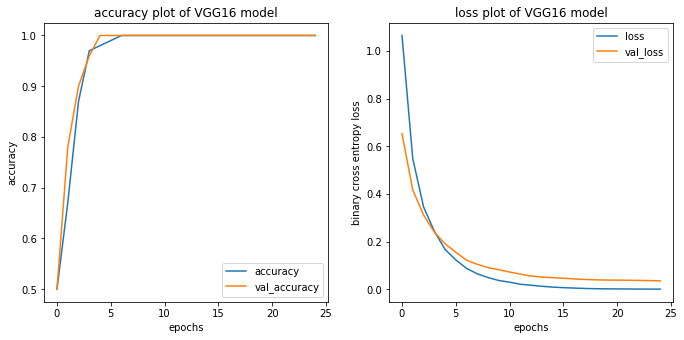

In [135]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout(pad=3)
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].legend(['accuracy', 'val_accuracy'])
ax[0].set(title='accuracy plot of VGG16 model', ylabel='accuracy', xlabel='epochs')
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].legend(['loss', 'val_loss'])
ax[1].set(title='loss plot of VGG16 model', ylabel='binary cross entropy loss', xlabel='epochs')
plt.show()

In [136]:
y_hat=[]
y=[]
for i in range(len(pairs_test_x)):
    a=siamese_net_1.predict([np.expand_dims(pairs_test_x[i][0],axis=0),np.expand_dims(pairs_test_x[i][1],axis=0)])
    if a[0][0]>0.5:
      y_hat.append(1)
    else:
      y_hat.append(0)
    y+=[pairs_test_y[i]]
print("accuracy of VGG16 model is",accuracy_score(y_hat,y))

accuracy of VGG16 model is 1.0


# ResNet50 based Transfer Learning Model

In [208]:
input1 = Input((SIZE,SIZE,3))
input2 = Input((SIZE,SIZE,3))
base_model = ResNet50(weights='imagenet',input_shape=(SIZE, SIZE, 3), include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='sigmoid')(x)
x = Dense(512, activation='sigmoid')(x)
for layer in base_model.layers:
    layer.trainable = False
resnet_model = Model(inputs=base_model.input, outputs=x)

resnet_encoded1 = resnet_model(input1)
resnet_encoded2 = resnet_model(input2)
    
output_layer = Lambda(cosine_similarity)([resnet_encoded1,resnet_encoded2])
siamese_net_2 = Model(inputs=[input1,input2],outputs=output_layer)

In [209]:
siamese_net_2.compile(loss = "binary_crossentropy", optimizer="adam", metrics=["accuracy"])
siamese_net_2.summary()

Model: "model_31"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_46 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_47 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model_30 (Functional)           (None, 512)          26210688    input_46[0][0]                   
                                                                 input_47[0][0]                   
__________________________________________________________________________________________________
lambda_15 (Lambda)              (None, 1)            0           model_30[0][0]            

In [210]:
a=pairs_train_x[:,0]
b=pairs_train_x[:,1]
c=pairs_test_x[:,0]
d=pairs_test_x[:,1]
history=siamese_net_2.fit([a,b], pairs_train_y,batch_size=50, epochs= 25, validation_data=([c,d], pairs_test_y))

Epoch 1/25
2/2 [==============================] - 8s 2s/step - loss: 2.7565 - accuracy: 0.4867 - val_loss: 1.7015 - val_accuracy: 0.5000
Epoch 2/25
2/2 [==============================] - 1s 678ms/step - loss: 1.6931 - accuracy: 0.4733 - val_loss: 1.0920 - val_accuracy: 0.5000
Epoch 3/25
2/2 [==============================] - 1s 667ms/step - loss: 0.9681 - accuracy: 0.5200 - val_loss: 0.7921 - val_accuracy: 0.5600
Epoch 4/25
2/2 [==============================] - 1s 667ms/step - loss: 0.6982 - accuracy: 0.6267 - val_loss: 0.6528 - val_accuracy: 0.6600
Epoch 5/25
2/2 [==============================] - 1s 664ms/step - loss: 0.5891 - accuracy: 0.6467 - val_loss: 0.5514 - val_accuracy: 0.6600
Epoch 6/25
2/2 [==============================] - 1s 675ms/step - loss: 0.4233 - accuracy: 0.7600 - val_loss: 0.4688 - val_accuracy: 0.7600
Epoch 7/25
2/2 [==============================] - 1s 676ms/step - loss: 0.3599 - accuracy: 0.8533 - val_loss: 0.4111 - val_accuracy: 0.7600
Epoch 8/25
2/2 [=======

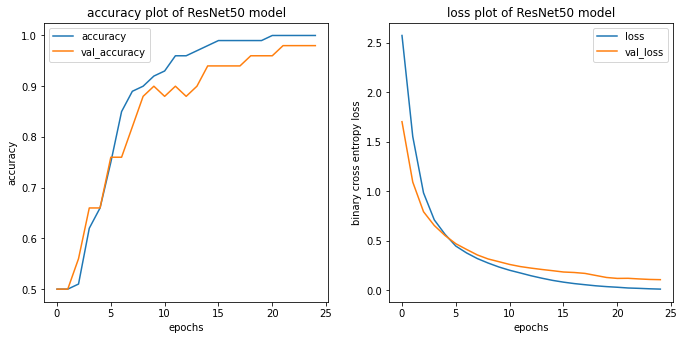

In [211]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout(pad=3)
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].legend(['accuracy', 'val_accuracy'])
ax[0].set(title='accuracy plot of ResNet50 model', ylabel='accuracy', xlabel='epochs')
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].legend(['loss', 'val_loss'])
ax[1].set(title='loss plot of ResNet50 model', ylabel='binary cross entropy loss', xlabel='epochs')
plt.show()

In [212]:
y_hat=[]
y=[]
for i in range(len(pairs_test_x)):
    a=siamese_net_2.predict([np.expand_dims(pairs_test_x[i][0],axis=0),np.expand_dims(pairs_test_x[i][1],axis=0)])
    if a[0][0]>0.5:
      y_hat.append(1)
    else:
      y_hat.append(0)
    y+=[pairs_test_y[i]]
print("accuracy of ResNet50 model is",accuracy_score(y_hat,y))

accuracy of ResNet50 model is 0.98


# EfficientNetB3 based Transfer Learning Model

In [175]:
input1 = Input((SIZE,SIZE,3))
input2 = Input((SIZE,SIZE,3))
base_model = tf.keras.applications.EfficientNetB3(weights='imagenet',input_shape=(SIZE, SIZE, 3), include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='sigmoid')(x)
x = Dense(512, activation='sigmoid')(x)
for layer in base_model.layers:
    layer.trainable = False
efficientnet_model = Model(inputs=base_model.input, outputs=x)

encoded1 = efficientnet_model(input1)
encoded2 = efficientnet_model(input2)
    
output_layer = Lambda(cosine_similarity)([encoded1,encoded2])
siamese_net_3 = Model(inputs=[input1,input2],outputs=output_layer)

In [176]:
siamese_net_3.compile(loss = "binary_crossentropy", optimizer="adam", metrics=["accuracy"])
siamese_net_3.summary()

Model: "model_25"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_37 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_38 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model_24 (Functional)           (None, 512)          12882223    input_37[0][0]                   
                                                                 input_38[0][0]                   
__________________________________________________________________________________________________
lambda_12 (Lambda)              (None, 1)            0           model_24[0][0]            

In [177]:
a=pairs_train_x[:,0]
b=pairs_train_x[:,1]
c=pairs_test_x[:,0]
d=pairs_test_x[:,1]
history=siamese_net_3.fit([a,b], pairs_train_y,batch_size=50, epochs= 30, validation_data=([c,d], pairs_test_y))

Epoch 1/30
2/2 [==============================] - 18s 4s/step - loss: 3.3236 - accuracy: 0.4933 - val_loss: 2.5395 - val_accuracy: 0.5000
Epoch 2/30
2/2 [==============================] - 1s 690ms/step - loss: 2.4161 - accuracy: 0.4867 - val_loss: 1.8530 - val_accuracy: 0.5000
Epoch 3/30
2/2 [==============================] - 1s 694ms/step - loss: 1.5843 - accuracy: 0.5133 - val_loss: 1.3655 - val_accuracy: 0.5000
Epoch 4/30
2/2 [==============================] - 1s 705ms/step - loss: 1.1769 - accuracy: 0.5000 - val_loss: 1.0372 - val_accuracy: 0.5000
Epoch 5/30
2/2 [==============================] - 1s 717ms/step - loss: 0.8112 - accuracy: 0.5533 - val_loss: 0.8271 - val_accuracy: 0.5400
Epoch 6/30
2/2 [==============================] - 1s 702ms/step - loss: 0.6799 - accuracy: 0.5933 - val_loss: 0.6686 - val_accuracy: 0.5600
Epoch 7/30
2/2 [==============================] - 1s 706ms/step - loss: 0.5420 - accuracy: 0.6533 - val_loss: 0.5188 - val_accuracy: 0.6400
Epoch 8/30
2/2 [======

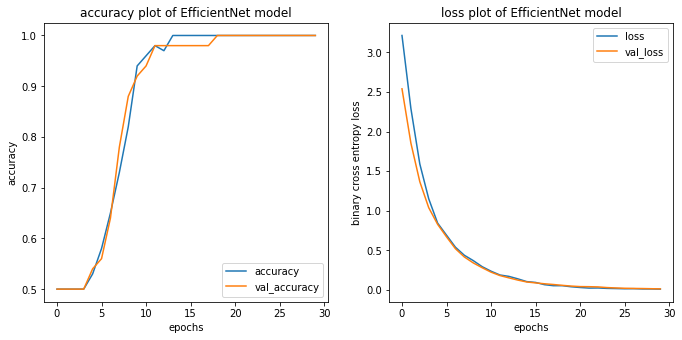

In [178]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout(pad=3)
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].legend(['accuracy', 'val_accuracy'])
ax[0].set(title='accuracy plot of EfficientNet model', ylabel='accuracy', xlabel='epochs')
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].legend(['loss', 'val_loss'])
ax[1].set(title='loss plot of EfficientNet model', ylabel='binary cross entropy loss', xlabel='epochs')
plt.show()

In [179]:
y_hat=[]
y=[]
for i in range(len(pairs_test_x)):
    a=siamese_net_3.predict([np.expand_dims(pairs_test_x[i][0],axis=0),np.expand_dims(pairs_test_x[i][1],axis=0)])
    if a[0][0]>0.5:
      y_hat.append(1)
    else:
      y_hat.append(0)
    y+=[pairs_test_y[i]]
print("accuracy of EfficientNet model is",accuracy_score(y_hat,y))

accuracy of EfficientNetB0 model is 1.0


# Test Predictions
---
A random image pair is chosen from the test set and the predictions for this test pair from all the 3 models is given

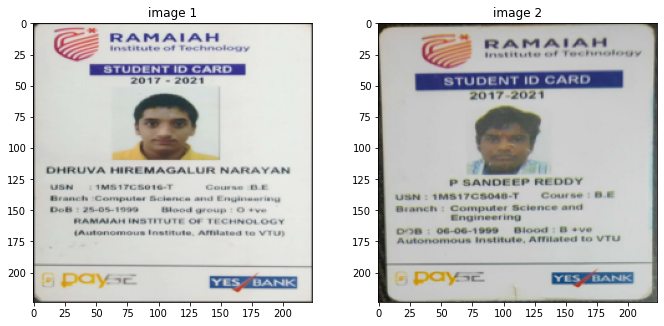

true label for the above pair: 1
prediction from VGG16 model: 0.9093601
prediction from ResNet50 model: 0.9834839
prediction from EfficientNetB3 model: 0.99414545


In [229]:
rand = random.randrange(0, pairs_test_x.shape[0], 1)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout(pad=3)
ax[0].imshow(pairs_test_x[rand][0])
ax[0].set(title='image 1')
ax[1].imshow(pairs_test_x[rand][1])
ax[1].set(title='image 2')
plt.show()

#predictions
print("true label for the above pair:",pairs_test_y[rand])
print("prediction from VGG16 model:",siamese_net_1.predict([np.expand_dims(pairs_test_x[rand][0],axis=0),np.expand_dims(pairs_test_x[rand][1],axis=0)])[0][0])
print("prediction from ResNet50 model:",siamese_net_2.predict([np.expand_dims(pairs_test_x[rand][0],axis=0),np.expand_dims(pairs_test_x[rand][1],axis=0)])[0][0])
print("prediction from EfficientNetB3 model:",siamese_net_3.predict([np.expand_dims(pairs_test_x[rand][0],axis=0),np.expand_dims(pairs_test_x[rand][1],axis=0)])[0][0])

# Embedings from the models
---
Passing all images through the 3 models to get the individual embeddings

In [148]:
#embedding of random image from VGG model
vgg_model.predict([np.expand_dims(pairs_test_x[rand][0],axis=0)]).shape

(1, 512)

In [149]:
#embedding of random image from resnet model
resnet_model.predict([np.expand_dims(pairs_test_x[rand][0],axis=0)]).shape

(1, 512)

In [150]:
#embedding of random image from efficientnet model
efficientnet_model.predict([np.expand_dims(pairs_test_x[rand][0],axis=0)]).shape

(1, 512)

In [213]:
vgg_embeddings = []
resnet_embeddings = []
efficientnet_embeddings = []
for i in X:
  efficientnet_embeddings.append(efficientnet_model.predict([np.expand_dims(i,axis=0)]))
  resnet_embeddings.append(resnet_model.predict([np.expand_dims(i,axis=0)]))
  vgg_embeddings.append(vgg_model.predict([np.expand_dims(i,axis=0)]))

In [152]:
print("no. of embeddings",len(efficientnet_embeddings),len(resnet_embeddings),len(vgg_embeddings))

no. of embeddings 75 75 75


# Cosine Similarity Matrices
---
Here we are plotting correlation matrices for the cosine similarities of embeddings from each model

* Ideally, items should have high intra class cosine similarity and low inter class cosine similarity

* The representation for the ideal cosine similarity is given at the bottom

In [181]:
efficientnet_matrix = []
for i in range(len(efficientnet_embeddings)):
  m = []
  for j in range(len(efficientnet_embeddings)):
    m.append(cosine_similarity([tf.constant(efficientnet_embeddings[i]),tf.constant(efficientnet_embeddings[j])]).numpy()[0][0])
  efficientnet_matrix.append(m)

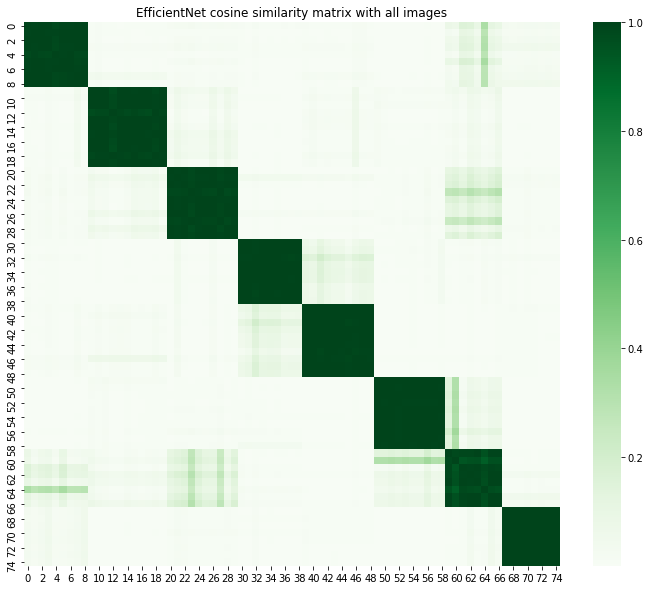

In [182]:
f, ax = plt.subplots(figsize=(12, 10))
ax.set(title='EfficientNet cosine similarity matrix with all images')
ax = sns.heatmap(np.array(efficientnet_matrix),cmap="Greens")

In [214]:
resnet_matrix = []
for i in range(len(resnet_embeddings)):
  m = []
  for j in range(len(resnet_embeddings)):
    m.append(cosine_similarity([tf.constant(resnet_embeddings[i]),tf.constant(resnet_embeddings[j])]).numpy()[0][0])
  resnet_matrix.append(m)

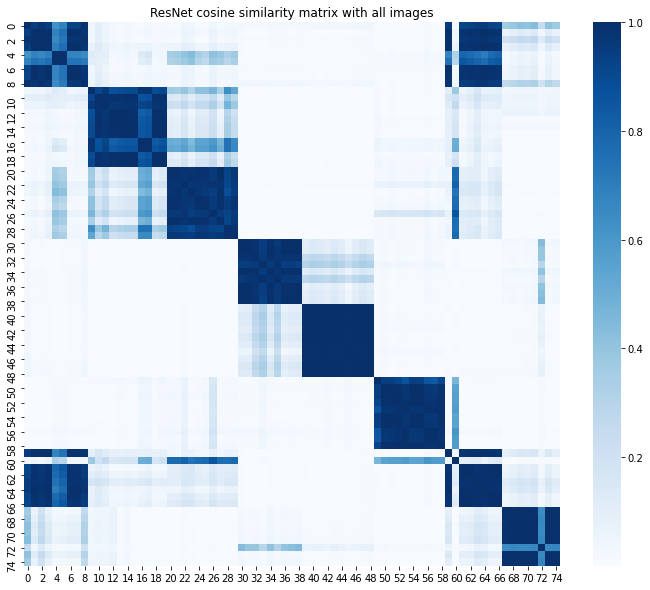

In [215]:
f, ax = plt.subplots(figsize=(12, 10))
ax.set(title='ResNet cosine similarity matrix with all images')
ax = sns.heatmap(np.array(resnet_matrix),cmap="Blues")

In [157]:
vgg_matrix = []
for i in range(len(vgg_embeddings)):
  m = []
  for j in range(len(vgg_embeddings)):
    m.append(cosine_similarity([tf.constant(vgg_embeddings[i]),tf.constant(vgg_embeddings[j])]).numpy()[0][0])
  vgg_matrix.append(m)

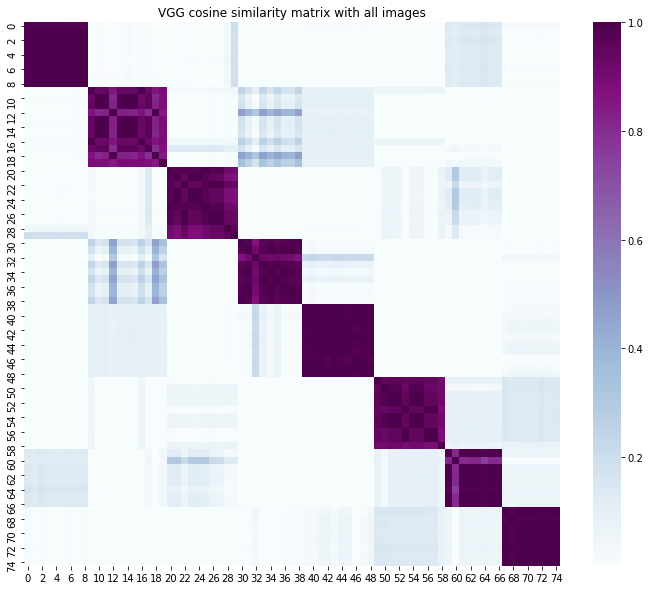

In [158]:
f, ax = plt.subplots(figsize=(12, 10))
ax.set(title='VGG cosine similarity matrix with all images')
ax = sns.heatmap(np.array(vgg_matrix),cmap="BuPu")

In [159]:
y = list(Y)
c = Counter(y)
counts = []
for i in c:
  counts.append(c[i])
n = sum(counts)
e = 0 
f = [0]*n
ideal_mat = []
for _ in range(n):
  ideal_mat.append(f[:])
for h in counts:
  for i in range(h):
    for j in range(h):
      ideal_mat[e+i][e+j] = 1
  e+=h

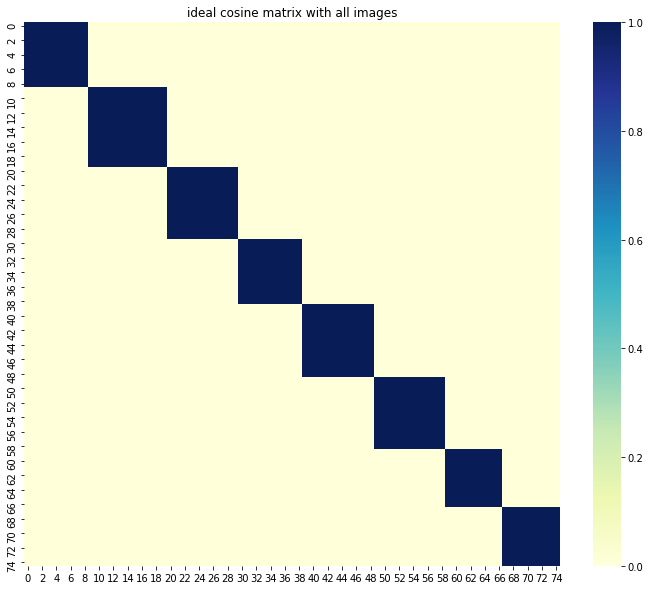

In [160]:
f, ax = plt.subplots(figsize=(12, 10))
ax.set(title='ideal cosine matrix with all images')
ax = sns.heatmap(np.array(ideal_mat),cmap="YlGnBu")

# Average embedding visualization
---
Getting the average value of all the embeddings from each of the classes and then calculating cosine similarity between those average embeddings and the embeddings for each individual image

In [161]:
def getavg(vects, n):
  avg = []
  for i in range(len(vects[0])):
    s = 0
    for vect in vects:
      s += vect[i]
    s = s/n
    avg.append(s)
  return tf.constant(avg)

In [216]:
vgg_avgarrays = []
resnet_avgarrays = []
efficientnet_avgarrays = []
e = 0 
for i in counts:
  av1 = getavg(vgg_embeddings[e:e+i], i)
  av2 = getavg(resnet_embeddings[e:e+i], i)
  av3 = getavg(efficientnet_embeddings[e:e+i], i)
  vgg_avgarrays.append(av1)
  resnet_avgarrays.append(av2)
  efficientnet_avgarrays.append(av3)
  e+=i

In [217]:
vgg_avg_matrix = []
resnet_avg_matrix = []
efficientnet_avg_matrix = []
for i in range(len(vgg_avgarrays)):
  m1 = []
  m2 = []
  m3 = []
  for j in range(len(vgg_embeddings)):
    m1.append(cosine_similarity([vgg_avgarrays[i],tf.constant(vgg_embeddings[j])]).numpy()[0][0])
    m2.append(cosine_similarity([resnet_avgarrays[i],tf.constant(resnet_embeddings[j])]).numpy()[0][0])
    m3.append(cosine_similarity([efficientnet_avgarrays[i],tf.constant(efficientnet_embeddings[j])]).numpy()[0][0])
  vgg_avg_matrix.append(m1)
  resnet_avg_matrix.append(m2)
  efficientnet_avg_matrix.append(m3)

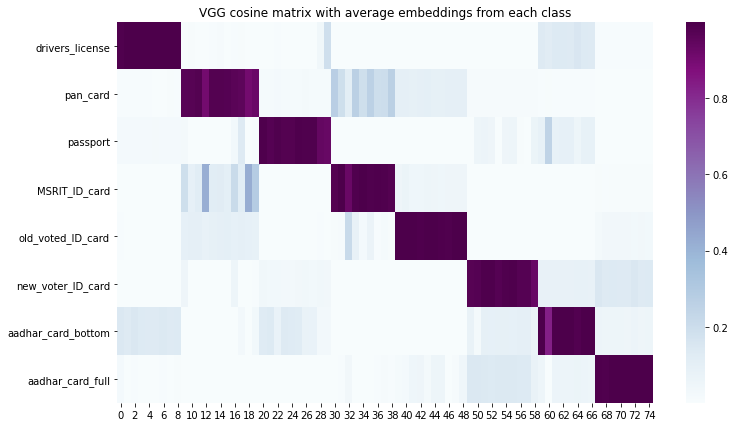

In [164]:
f, ax = plt.subplots(figsize=(12, 7))
ax.set(title='VGG cosine matrix with average embeddings from each class')
ax = sns.heatmap(np.array(vgg_avg_matrix),cmap="BuPu",yticklabels=class_names)

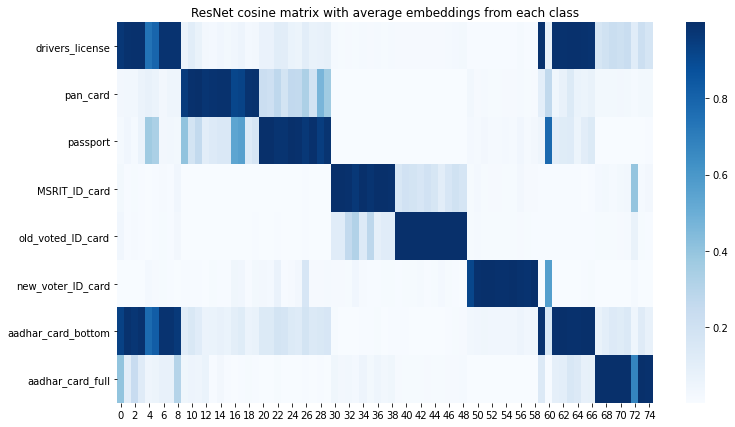

In [218]:
f, ax = plt.subplots(figsize=(12, 7))
ax.set(title='ResNet cosine matrix with average embeddings from each class')
ax = sns.heatmap(np.array(resnet_avg_matrix),cmap="Blues",yticklabels=class_names)

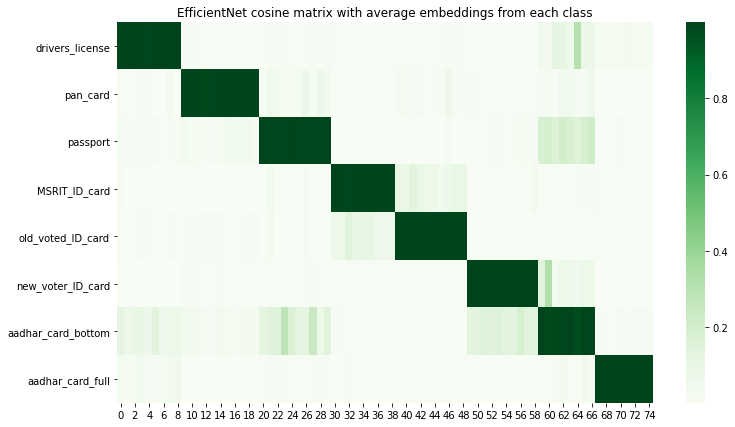

In [185]:
f, ax = plt.subplots(figsize=(12, 7))
ax.set(title='EfficientNet cosine matrix with average embeddings from each class')
ax = sns.heatmap(np.array(efficientnet_avg_matrix),cmap="Greens",yticklabels=class_names)

# Tabulating data to store in database

In [219]:
table_data = []
for h,i,j,k in zip(Y, vgg_embeddings, resnet_embeddings, efficientnet_embeddings):
  m = [h,i[0], j[0], k[0]]
  table_data.append(m)

m = np.array(table_data)
print("data shape:",m.shape)

data shape: (75, 4)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [220]:
old = list(range(len(class_names)))
df = pd.DataFrame(data = m, columns = ['class', 'vgg_embeddings', 'resnet_embeddings', 'efficientnet_embeddings'])
df['class'] = df['class'].replace(old,class_names)
df

,class,vgg_embeddings,resnet_embeddings,efficientnet_embeddings
0,drivers_license,"[0.0016127542, 2.9196605e-07, 0.89552104, 1.42...","[0.0018186831, 6.9757254e-05, 0.00019155492, 3...","[8.101638e-05, 0.0003530471, 0.00016248181, 5...."
1,drivers_license,"[0.0006696395, 1.195674e-07, 0.96324, 2.634171...","[0.00018078572, 0.00017455583, 0.0001151631, 6...","[0.00012302403, 0.0005518437, 0.0001337753, 5...."
2,drivers_license,"[0.00047019924, 5.1919915e-08, 0.98878247, 8.5...","[0.00086231186, 7.796749e-05, 0.00014535454, 3...","[7.523149e-05, 0.00035502628, 0.00015790503, 5..."
3,drivers_license,"[1.7037302e-05, 9.651505e-09, 0.9600248, 7.715...","[0.0002125604, 0.00016793144, 0.00013210962, 7...","[4.0666062e-05, 0.00024838326, 0.0001629945, 9..."
4,drivers_license,"[6.663281e-06, 3.0383706e-07, 0.9042692, 1.033...","[1.6986913e-05, 0.00068823283, 0.0005637132, 0...","[0.0002201235, 0.00044129562, 8.607015e-05, 3...."
...,...,...,...,...
70,aadhar_card_full,"[0.998879, 5.2513244e-10, 1.9575424e-05, 3.267...","[0.0011630733, 4.190914e-05, 0.00012438787, 1....","[1.1847138e-05, 0.00010669073, 0.00050937495, ..."
71,aadhar_card_full,"[0.999495, 1.6267387e-09, 2.302554e-05, 3.7408...","[0.0022019593, 3.189543e-05, 0.00015324146, 1....","[1.0088487e-05, 0.00010533048, 0.00047828245, ..."
72,aadhar_card_full,"[0.9643186, 9.1967486e-05, 0.00066105486, 1.08...","[0.0024739867, 0.00013253241, 0.0005856463, 5....","[1.8006429e-05, 0.00011379746, 0.000417071, 8...."
73,aadhar_card_full,"[0.99958485, 1.0803385e-07, 6.064984e-05, 1.22...","[0.0015747524, 3.2464748e-05, 0.00013204475, 1...","[1.389308e-05, 0.00012248184, 0.00047623095, 0..."


In [221]:
df.to_json('embeddings.json',orient='records')

# Saving models

In [188]:
# vgg_model.save("vgg_model.h5")
# resnet_model.save("resnet_model.h5")
# efficientnet_model.save("efficientnet_model.h5")